# Subtracting Cardinal Bias 

- Generate predicted values using the sawtooth function based on the x-values.
- Interpolate the predicted values to align with the length of the serial bias array.
- Create a copy of the serial bias array to represent the original bias.
- Subtract the predicted sawtooth values from the residuals array for cases where the cardinal bias is greater than or equal to 0.
- Add the predicted sawtooth values to the residuals array for cases where the cardinal bias is less than 0.
- Plot the original serial bias and the residuals after removing the sawtooth shape side by side.

Other option:
*starting point could be take the average function could see if that cleans up the rough serial dependence 

In [22]:
# imports/ helper functions
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
pi=np.pi
pm = np.array((-1,1))
r2d,d2r = 180/pi,pi/180
r2d2,d2r2  = 90/pi,pi/90
ori_wrap = lambda x: SDF.wrap(x*2)/2

# modules from this package.
import SD_functions as SDF
import responseModel as RM

def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)

In [51]:
# load the data 

data = pd.read_csv('data/hollypooleddata.csv')
data.head()
display(data)

# # Replace empty or whitespace values with NaN
# data.replace(" ", np.NaN, inplace=True)


,orient,distractor,kappa,subject,resp,respRT,acc,traj
0,47,0.00,100,2,NaN,0.000000,NaN,0.0
1,143,1.00,5000,2,153.0,2.423917,10.0,50.0
2,84,0.00,50,2,NaN,0.000000,NaN,0.0
3,104,0.00,100,2,106.0,1.882485,2.0,-19.0
4,161,1.00,50,2,NaN,0.000000,NaN,0.0
...,...,...,...,...,...,...,...,...
15115,117,1.00,100,43,99.0,2.541777,-18.0,70.0
15116,109,0.15,5000,43,127.0,2.506347,18.0,-17.0
15117,101,1.00,5000,43,104.0,2.541367,3.0,-13.0
15118,159,0.15,50,43,21.0,2.541478,42.0,-156.0


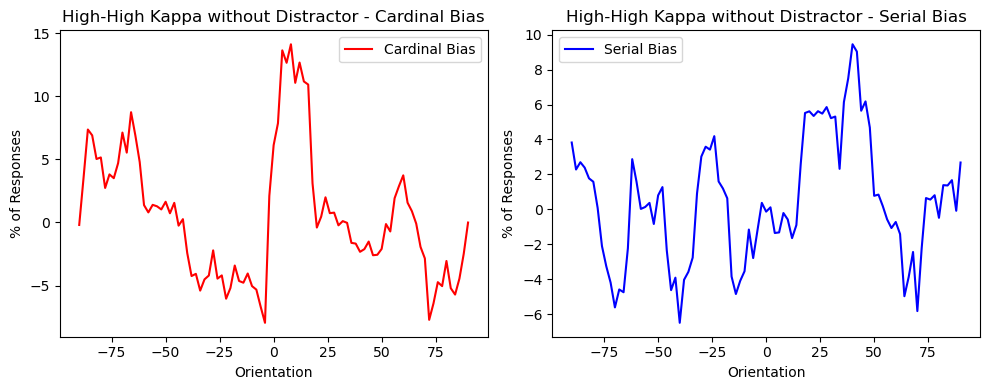

Number of pairs:  191


In [26]:
#High high no distractor 
# Initialize an empty list to store the high-low kappa pairs with distractor = 0
high_high_no_distractor_pairs = []

# Loop through each row in the DataFrame
for i in range(1, len(data)):
    # Check if Kappa is 5000 and distractor is 0 for both the current row and the previous row
    if data.iloc[i]["kappa"] == 5000 and data.iloc[i]["distractor"] == 0 and data.iloc[i-1]["kappa"] == 5000 and data.iloc[i-1]["distractor"] == 0:
        # If the conditions are met, append the entire row to the list
        high_high_no_distractor_pairs.append(data.iloc[i-1])
        high_high_no_distractor_pairs.append(data.iloc[i])

# Create a new DataFrame from the selected rows
high_high_no_distractor_pairs_data = pd.DataFrame(high_high_no_distractor_pairs)

#bias plotting
nb=-1
d_ori = SDF.get_nb(nb,high_high_no_distractor_pairs_data['orient'].values,1,ori_wrap) # dStim_nb
tmp_ori = SDF.wrap(high_high_no_distractor_pairs_data.orient * 2) / 2


n_bns = 91
bns = np.linspace(-90,90,n_bns)
overlap = 3

# ind = (np.isnan(data['acc']))
# tmp_data = data['acc'][ind==False]
# tmp_ori = data.orient[ind==False]
high_high_no_distractor_sd = SDF.do_bining(bns,overlap,d_ori,high_high_no_distractor_pairs_data['acc']*d2r2,want_var='circ_mean')*r2d2
high_high_no_distractor_cb = SDF.do_bining(bns,overlap,tmp_ori, high_high_no_distractor_pairs_data['acc']*d2r2,want_var='circ_mean')*r2d2

#####################################
#Plotting the CARDINAL BIAS

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the CARDINAL BIAS
axes[0].plot(bns, high_high_no_distractor_cb, color='r', label='Cardinal Bias')
axes[0].set_xlabel('Orientation')
axes[0].set_ylabel('% of Responses')
axes[0].set_title('High-High Kappa without Distractor - Cardinal Bias')
axes[0].legend()

# Plotting the SERIAL BIAS
axes[1].plot(bns, high_high_no_distractor_sd, color='b', label='Serial Bias')
axes[1].set_xlabel('Orientation')
axes[1].set_ylabel('% of Responses')
axes[1].set_title('High-High Kappa without Distractor - Serial Bias')
axes[1].legend()

plt.tight_layout()
plt.show()


# To see the number of pairs that meet the condition Kappa == 5000 and distractor == 0 in the resulting high_low_data DataFrame, you can use the len() function. Here's an example:

pair_count = len(high_high_no_distractor_pairs_data) // 2  # Divide by 2 since each pair is represented by two rows
print("Number of pairs: ", pair_count)


# Fitting a sawtooth regressor: 

To create a regressor that resembles the cardinal bias curve (sawtooth function) and then remove it before analyzing the serial bias curve:


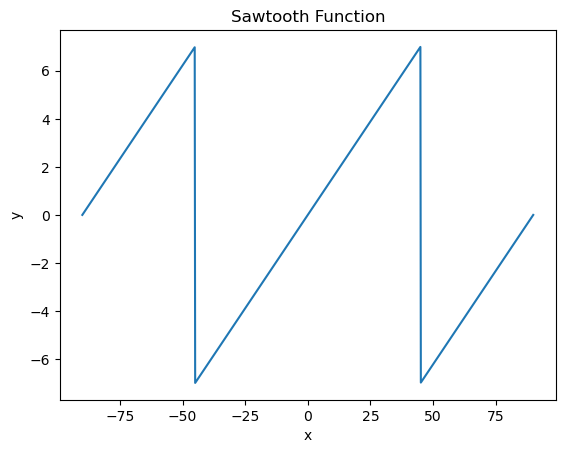

In [42]:
#Visualizing a sawtooth function: 

# def sawtooth(x, amplitude, period):
#     return amplitude * (2 * np.arctan(np.tan((np.pi * x) / period)) / np.pi - 1)

def sawtooth(x, amplitude, period):
    return amplitude * (2 * np.mod(x + period / 2, period) / period - 1)

amplitude = 7.0  # Set the amplitude of the sawtooth
period = 90.0  # Set the period of the sawtooth


x_values = np.linspace(-90, 90, num=1000)  # Generate x-values for the plot
y_values = sawtooth(x_values, amplitude, period)  # Calculate the corresponding y-values

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sawtooth Function')
plt.show()


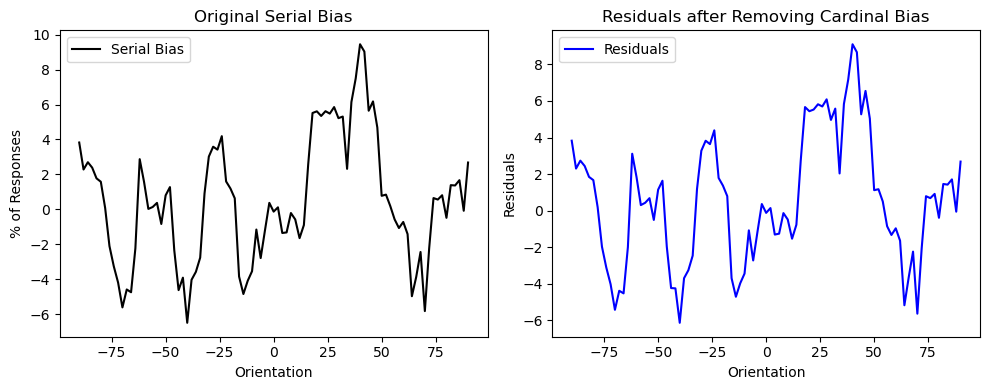

Number of pairs: 191


In [43]:
# Generate the predicted values using the regressor and the sawtooth function
x_values = np.linspace(-90, 90, num=len(high_high_no_distractor_sd))
predicted_values = sawtooth(x_values, regressor.coef_[0][0] * amplitude, period)

# Interpolate the predicted values to match the length of high_high_no_distractor_sd
predicted_values_interpolated = np.interp(np.arange(len(high_high_no_distractor_sd)), np.arange(len(predicted_values)), predicted_values)

# Removing the cardinal bias from the current trial
residuals = high_high_no_distractor_sd.copy()
residuals[high_high_no_distractor_cb >= 0] -= predicted_values_interpolated[high_high_no_distractor_cb >= 0]
residuals[high_high_no_distractor_cb < 0] += predicted_values_interpolated[high_high_no_distractor_cb < 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

########################
# Plotting the original SERIAL BIAS
axes[0].plot(bns, high_high_no_distractor_sd, color='black', label='Serial Bias')
axes[0].set_xlabel('Orientation')
axes[0].set_ylabel('% of Responses')
axes[0].set_title('Original Serial Bias')
axes[0].legend()

# Plotting the residuals after removing the sawtooth shape
axes[1].plot(bns, residuals, color='blue', label='Residuals')
axes[1].set_xlabel('Orientation')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals after Removing Cardinal Bias')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print the number of pairs in the high_high_no_distractor_pairs_data DataFrame
pair_count = len(high_high_no_distractor_pairs_data) // 2
print("Number of pairs:", pair_count)

# Option 2: 
*starting point could be take the average function could see if that cleans up the rough serial dependence 

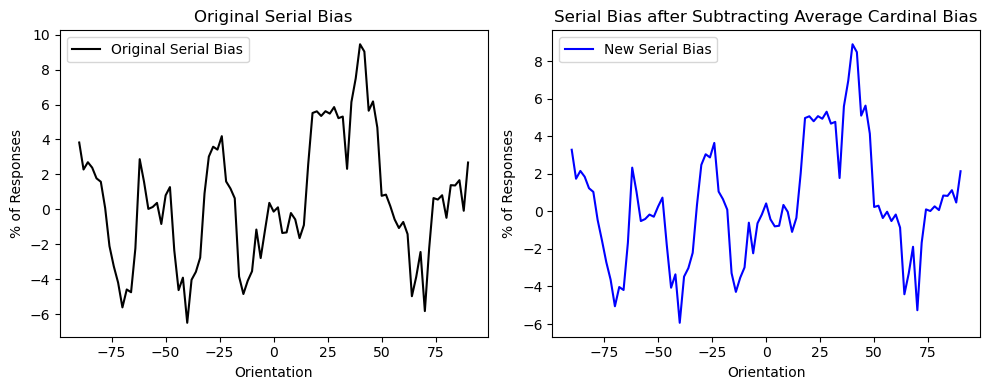

In [50]:
# Calculate the average cardinal bias
average_cardinal_bias = np.mean(high_high_no_distractor_cb)

# Subtract or add the average cardinal bias based on the sign of the serial bias
new_serial_bias = high_high_no_distractor_sd.copy()

positive_indices = new_serial_bias >= 0
negative_indices = new_serial_bias < 0

new_serial_bias[positive_indices] -= average_cardinal_bias
new_serial_bias[negative_indices] += average_cardinal_bias

# Plot the original serial bias and the new serial bias
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the original serial bias
axes[0].plot(bns, high_high_no_distractor_sd, color='black', label='Original Serial Bias')
axes[0].set_xlabel('Orientation')
axes[0].set_ylabel('% of Responses')
axes[0].set_title('Original Serial Bias')
axes[0].legend()

# Plotting the new serial bias
axes[1].plot(bns, new_serial_bias, color='blue', label='New Serial Bias')
axes[1].set_xlabel('Orientation')
axes[1].set_ylabel('% of Responses')
axes[1].set_title('Serial Bias after Subtracting Average Cardinal Bias')
axes[1].legend()

plt.tight_layout()
plt.show()